Importing Libraries

In [1]:
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import warnings
warnings.filterwarnings('ignore')

Importing Dataset

In [3]:
data = pd.read_csv("data_set.csv")
data.head()

,YEAR,MO,DY,T2M,T2MDEW,QV2M,RH2M,PRECTOTCORR,PS,WS10M
0,1981,2,1,14.98,11.94,8.79,82.56,5.52,100.03,3.10
1,1981,2,2,15.78,11.65,8.61,78.06,0.04,100.02,2.02
2,1981,2,3,15.36,11.64,8.54,80.38,0.75,100.07,2.30
3,1981,2,4,15.77,11.55,8.54,77.62,0.00,99.94,2.19
4,1981,2,5,16.55,11.87,8.73,76.00,0.00,100.03,2.04


In [4]:
data.shape

(15368, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15368 entries, 0 to 15367
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         15368 non-null  int64  
 1   MO           15368 non-null  int64  
 2   DY           15368 non-null  int64  
 3   T2M          15368 non-null  float64
 4   T2MDEW       15368 non-null  float64
 5   QV2M         15368 non-null  float64
 6   RH2M         15368 non-null  float64
 7   PRECTOTCORR  15368 non-null  float64
 8   PS           15368 non-null  float64
 9   WS10M        15368 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 1.2 MB


In [6]:
# Combine YEAR, MO, DY into a single Date column
data['Date'] = pd.to_datetime(data[['YEAR', 'MO', 'DY']].rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'}))
data.drop(columns=['YEAR', 'MO', 'DY'], inplace=True)

# Rename columns to match conventions
data.rename(columns={
    'T2M': 'Temperature_2m',
    'T2MDEW': 'Dew_Point_Temperature_2m',
    'QV2M': 'Specific_Humidity_2m',
    'RH2M': 'Relative_Humidity_2m',
    'PRECTOTCORR': 'Precipitation',
    'PS': 'Surface_Pressure',
    'WS10M': 'Wind_Speed_10m'
}, inplace=True)

In [7]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Temperature_2m,15368.0,23.769878,-999.0,19.4975,25.56,28.24,33.86,15.143121
Dew_Point_Temperature_2m,15368.0,18.227975,-999.0,12.83,19.44,24.55,27.53,15.535352
Specific_Humidity_2m,15368.0,14.170456,-999.0,9.34,14.34,19.71,23.68,15.094699
Relative_Humidity_2m,15368.0,73.559393,-999.0,66.985,77.0,82.69,94.81,19.248063
Precipitation,15368.0,4.65651,-999.0,0.0,0.4,5.04,183.78,17.329175
Surface_Pressure,15368.0,99.026087,-999.0,98.77,99.25,99.71,100.69,15.353508
Wind_Speed_10m,15368.0,2.442391,-999.0,2.12,2.57,3.05,9.38,14.013726
Date,15368,2002-02-14 12:00:00,1981-02-01 00:00:00,1991-08-09 18:00:00,2002-02-14 12:00:00,2012-08-22 06:00:00,2023-02-28 00:00:00,NaN


In [8]:
for col in data.columns:
    data[col] = data[col].replace(-999, np.nan)

# Impute missing values with column medians
data.fillna(data.median(), inplace=True)

# Add cyclical features for day of year
data['DayOfYear_sin'] = np.sin(2 * np.pi * data['Date'].dt.dayofyear / 365)
data['DayOfYear_cos'] = np.cos(2 * np.pi * data['Date'].dt.dayofyear / 365)


In [9]:
data.dtypes

Temperature_2m                     float64
Dew_Point_Temperature_2m           float64
Specific_Humidity_2m               float64
Relative_Humidity_2m               float64
Precipitation                      float64
Surface_Pressure                   float64
Wind_Speed_10m                     float64
Date                        datetime64[ns]
DayOfYear_sin                      float64
DayOfYear_cos                      float64
dtype: object

In [10]:
data.index = data["Date"]

In [11]:
data.index

DatetimeIndex(['1981-02-01', '1981-02-02', '1981-02-03', '1981-02-04',
               '1981-02-05', '1981-02-06', '1981-02-07', '1981-02-08',
               '1981-02-09', '1981-02-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='Date', length=15368, freq=None)

<Axes: xlabel='Date'>

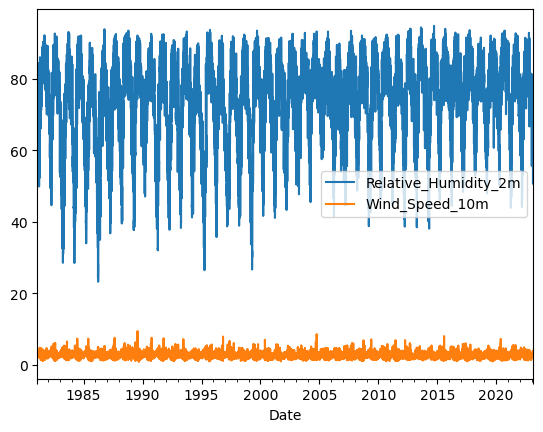

In [12]:
data[["Relative_Humidity_2m", "Wind_Speed_10m"]].plot()

<Axes: xlabel='Date'>

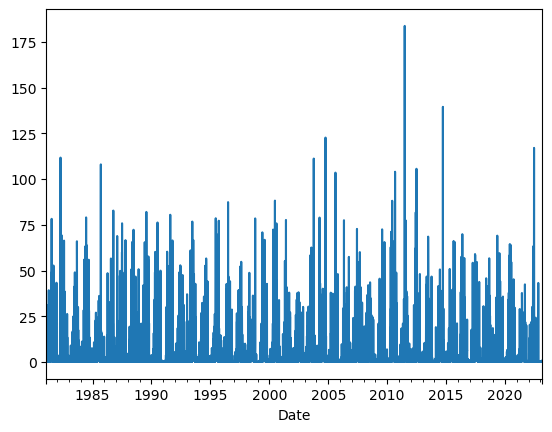

In [13]:
data["Precipitation"].plot()

In [14]:
data['Rain Today'] = data['Precipitation'].apply(lambda x:1 if x>0 else 0)
data['Rain Tomorrow'] = data['Rain Today'].shift(-1)

In [15]:
data = data.dropna().reset_index(drop=True)
data

,Temperature_2m,Dew_Point_Temperature_2m,Specific_Humidity_2m,Relative_Humidity_2m,Precipitation,Surface_Pressure,Wind_Speed_10m,Date,DayOfYear_sin,DayOfYear_cos,Rain Today,Rain Tomorrow
0,14.98,11.94,8.79,82.56,5.52,100.03,3.10,1981-02-01,0.523416,0.852078,1,1.0
1,15.78,11.65,8.61,78.06,0.04,100.02,2.02,1981-02-02,0.538005,0.842942,1,1.0
2,15.36,11.64,8.54,80.38,0.75,100.07,2.30,1981-02-03,0.552435,0.833556,1,0.0
3,15.77,11.55,8.54,77.62,0.00,99.94,2.19,1981-02-04,0.566702,0.823923,0,0.0
4,16.55,11.87,8.73,76.00,0.00,100.03,2.04,1981-02-05,0.580800,0.814046,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15362,22.79,13.15,9.52,57.62,0.01,99.41,3.48,2023-02-23,0.801361,0.598181,1,0.0
15363,21.04,11.44,8.48,56.12,0.00,99.79,2.77,2023-02-24,0.811539,0.584298,0,0.0
15364,21.41,12.61,9.09,60.12,0.00,100.12,3.23,2023-02-25,0.821477,0.570242,0,0.0
15365,22.23,12.56,9.09,57.19,0.00,100.15,3.05,2023-02-26,0.831171,0.556017,0,0.0


In [16]:
# Defining features and target
features = ['Temperature_2m', 'Dew_Point_Temperature_2m', 'Specific_Humidity_2m',
            'Relative_Humidity_2m', 'Precipitation', 'Surface_Pressure',
            'Wind_Speed_10m', 'DayOfYear_sin', 'DayOfYear_cos']
target = 'Rain Tomorrow'

In [17]:
X = data[features]
y = data[target]

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier()
}

In [21]:
# Hyperparameters for tuning
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

In [22]:
# Performing grid search to find the best models
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=2, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

Fitting 2 folds for each of 108 candidates, totalling 216 fits
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, classification_report, confusion_matrix
import seaborn as sns

In [24]:
def backtest(weather, model, predictors, start=10000, step=1000):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i + step), :]

        model.fit(train[predictors], train["Rain Tomorrow"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)

        combined = pd.concat([test["Rain Tomorrow"], preds], axis=1)
        combined.columns = ["actual", "predictions"]

        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [25]:
results = {}

# Perform backtesting and store the results
for model_name, model in best_models.items():
    predictions = backtest(data, model, features)
    results[model_name] = predictions

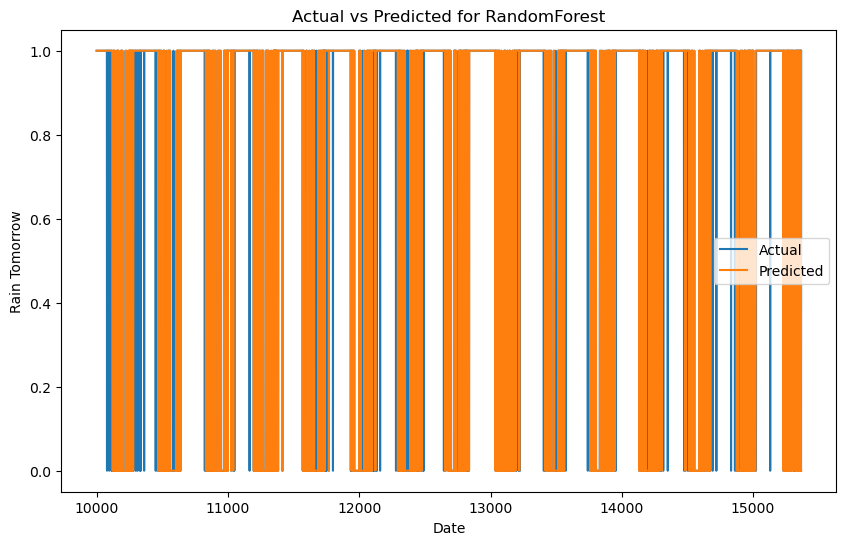

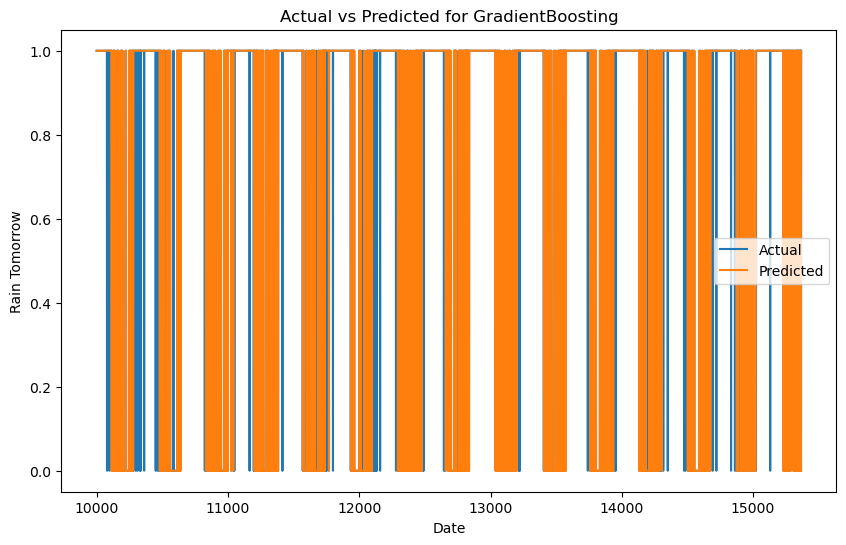

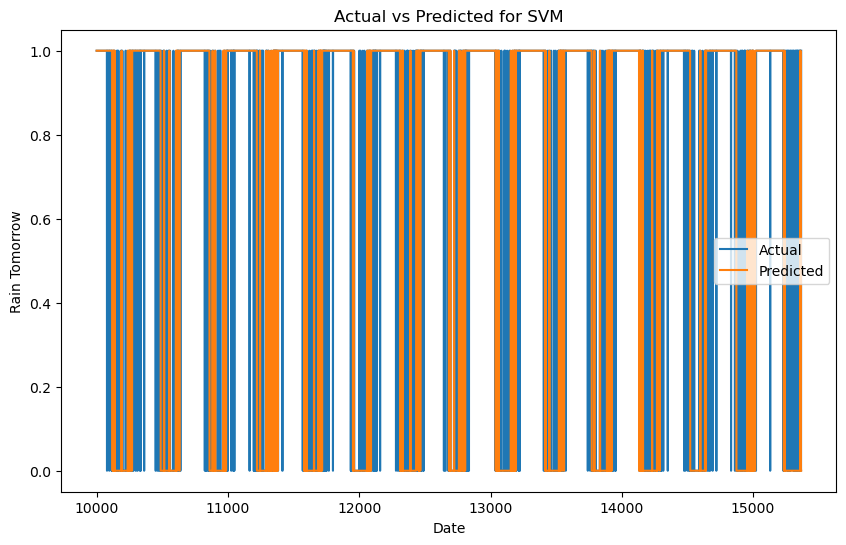

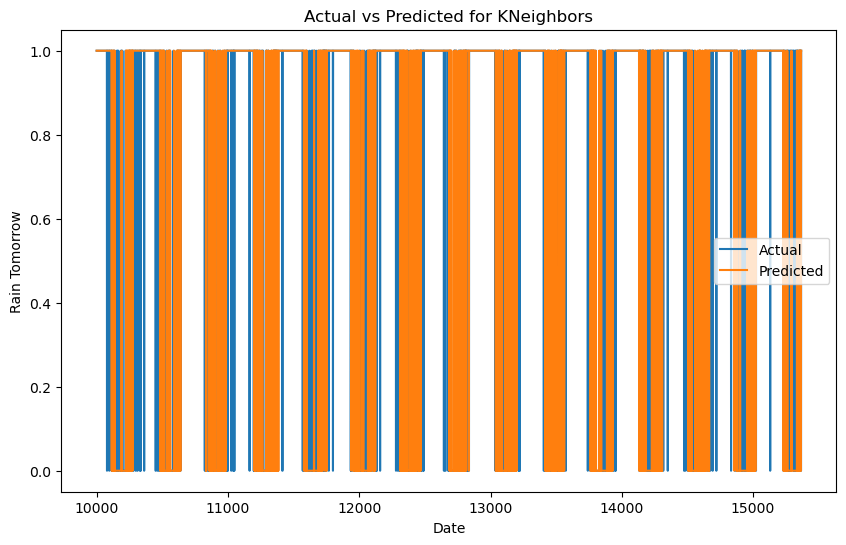

In [26]:
# Visualize the actual and predicted values for each model
for model_name, df in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['actual'], label='Actual')
    plt.plot(df.index, df['predictions'], label='Predicted')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Rain Tomorrow')
    plt.legend()
    plt.show()

RandomForest Mean Absolute Error (MAE): 0.0907612231620039
RandomForest R²: 0.5818410974132193
RandomForest Accuracy: 90.92387768379962%
Classification Report for RandomForest:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       979
         1.0       0.94      0.93      0.93      2095

    accuracy                           0.91      3074
   macro avg       0.89      0.90      0.90      3074
weighted avg       0.91      0.91      0.91      3074

Confusion Matrix for RandomForest:


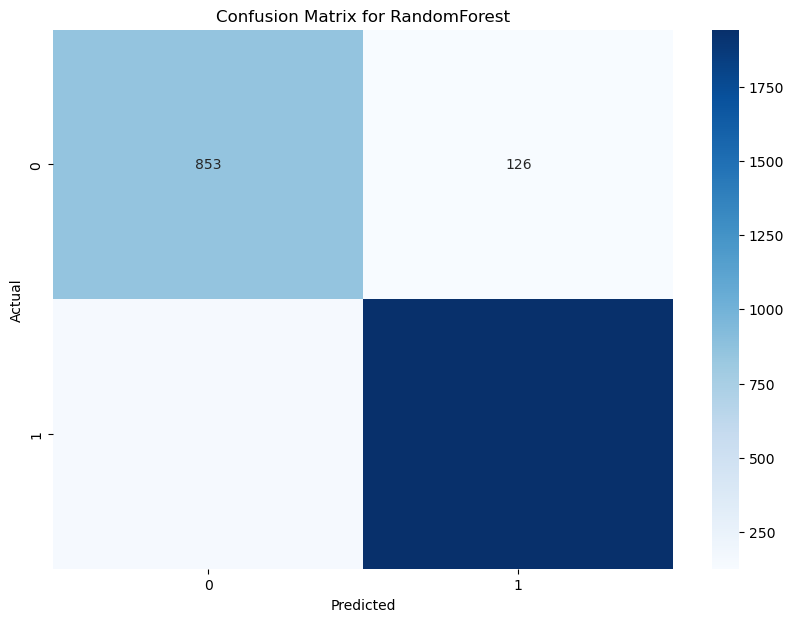

GradientBoosting Mean Absolute Error (MAE): 0.11548471047495121
GradientBoosting R²: 0.46793401283760894
GradientBoosting Accuracy: 88.45152895250487%
Classification Report for GradientBoosting:
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       979
         1.0       0.91      0.92      0.92      2095

    accuracy                           0.88      3074
   macro avg       0.87      0.86      0.87      3074
weighted avg       0.88      0.88      0.88      3074

Confusion Matrix for GradientBoosting:


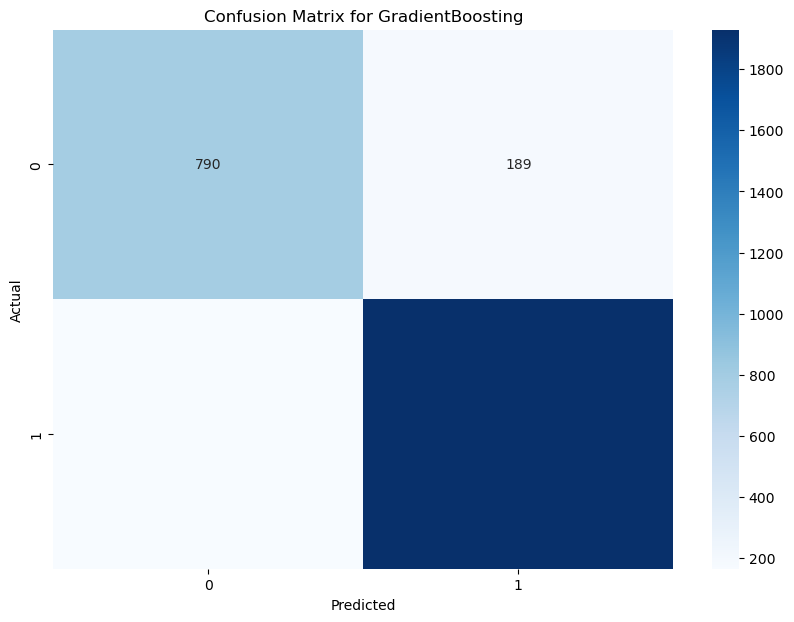

SVM Mean Absolute Error (MAE): 0.15452179570592062
SVM R²: 0.28808072140243446
SVM Accuracy: 84.54782042940793%
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78       979
         1.0       0.93      0.84      0.88      2095

    accuracy                           0.85      3074
   macro avg       0.82      0.85      0.83      3074
weighted avg       0.86      0.85      0.85      3074

Confusion Matrix for SVM:


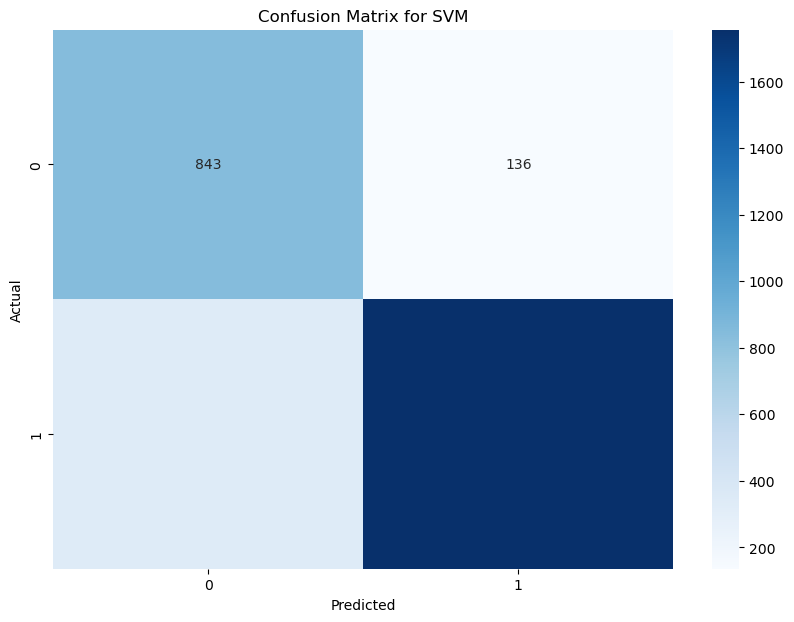

KNeighbors Mean Absolute Error (MAE): 0.1324007807417046
KNeighbors R²: 0.38999758654903327
KNeighbors Accuracy: 86.75992192582954%
Classification Report for KNeighbors:
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       979
         1.0       0.92      0.88      0.90      2095

    accuracy                           0.87      3074
   macro avg       0.84      0.86      0.85      3074
weighted avg       0.87      0.87      0.87      3074

Confusion Matrix for KNeighbors:


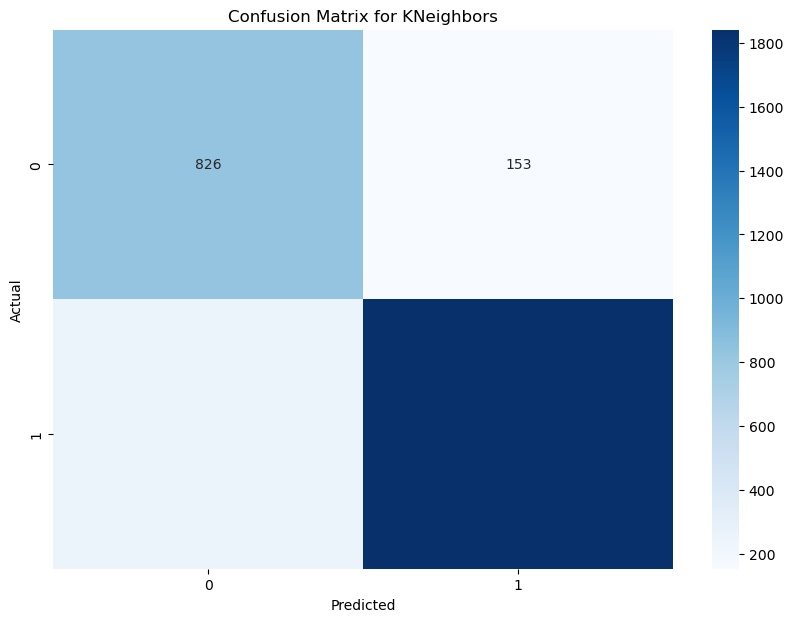

In [27]:
# Evaluate models on the test set and print metrics
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calculate MAE and R²
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} Mean Absolute Error (MAE): {mae}')
    print(f'{model_name} R²: {r2}')

    if hasattr(model, 'predict_proba'):
        accuracy = accuracy_score(y_test, y_pred)
        print(f'{model_name} Accuracy: {accuracy*100}%')
        print(f'Classification Report for {model_name}:')
        print(classification_report(y_test, y_pred))
        print(f'Confusion Matrix for {model_name}:')
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

In [28]:
best_model_name = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(X_test)))
best_model = best_models[best_model_name]

print(f'Best Model: {best_model_name}')

Best Model: RandomForest


In [29]:
import joblib
import pickle
joblib_file = "best_model.pkl"
joblib.dump(best_model, joblib_file)


# Confirming the model is saved and can be loaded
# Load the model using joblib
loaded_model_joblib = joblib.load(joblib_file)
print("Model loaded using joblib:", loaded_model_joblib)


Model loaded using joblib: RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)
